# MLLoopOptSelector — Research Dashboard

Interactive report for pipeline outputs in **artifacts/**:

- Training summary (`report.json` / `.txt`)
- Cross-validation (`cv.json`)
- Leave-One-Kernel-Out (`loko.json`)
- Feature importances (`feature_importance.csv`)
- Visuals (`tile_runtime_3d.png`, `explain.png`)

> Tip: run `make workflow` first, then re-run this notebook.

In [2]:
# Imports & setup
import json, os, math
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from IPython.display import display, Image

ART = Path("../artifacts")
ART.mkdir(exist_ok=True)

def load_json(p):
    p = ART / p if not str(p).startswith("/") else Path(p)
    return json.loads(p.read_text()) if p.exists() else None

def exists(rel):
    return (ART / rel).exists()

print("Artifacts directory:", ART.resolve())

Artifacts directory: /Users/ayesharahman1/Desktop/MLLoopOptSelector/artifacts


In [3]:
report = load_json("report.json")
cv     = load_json("cv.json")
loko   = load_json("loko.json")

fi = None
fi_csv = ART / "feature_importance.csv"
if fi_csv.exists():
    fi = pd.read_csv(fi_csv, header=None, names=["feature","importance"])\
           .sort_values("importance", ascending=False)

df = None
dataset_csv = ART / "dataset.csv"
if dataset_csv.exists():
    df = pd.read_csv(dataset_csv)

print("Loaded:")
print(" - report.json:", report is not None)
print(" - cv.json:", cv is not None)
print(" - loko.json:", loko is not None)
print(" - feature_importance.csv:", fi is not None)
print(" - dataset.csv:", df is not None)


Loaded:
 - report.json: True
 - cv.json: True
 - loko.json: True
 - feature_importance.csv: True
 - dataset.csv: True


In [4]:
if report:
    rows = [
        ("Model picked", report.get("model_picked")),
        ("Select-by", report.get("select_by")),
        ("Train Acc", f"{report.get('train_acc', float('nan')):.3f}"),
        ("Test Acc",  f"{report.get('test_acc', float('nan')):.3f}"),
        ("Train F1 (macro)", f"{report.get('train_f1_macro', float('nan')):.3f}"),
        ("Test F1 (macro)",  f"{report.get('test_f1_macro', float('nan')):.3f}"),
        ("Val median regret", f"{report.get('val_med_regret', float('nan')):.3f}"),
        ("CV Acc (mean)", f"{report.get('cv_acc_mean', float('nan')):.3f}"),
        ("CV F1 (macro mean)", f"{report.get('cv_f1_macro_mean', float('nan')):.3f}"),
        ("n_train", report.get("n_train")),
        ("n_test", report.get("n_test")),
        ("Cost-weighting", report.get("cost_weighting")),
    ]
    display(pd.DataFrame(rows, columns=["Metric","Value"]))
else:
    print("report.json not found — run `make workflow`.")


,Metric,Value
0,Model picked,ExtraTrees (sel_by=f1)
1,Select-by,f1
2,Train Acc,0.950
3,Test Acc,0.852
4,Train F1 (macro),0.892
5,Test F1 (macro),0.445
6,Val median regret,1.000
7,CV Acc (mean),0.757
8,CV F1 (macro mean),0.489
9,n_train,861


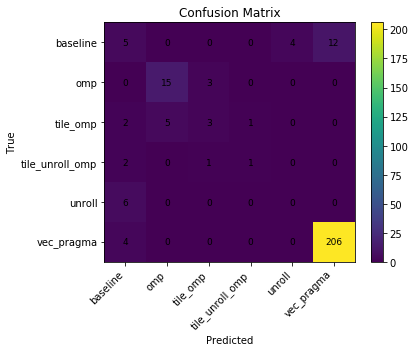

In [5]:
if report and report.get("confusion_matrix") is not None:
    labels = report.get("classes", [])
    cm = np.array(report["confusion_matrix"])
    if cm.size > 0:
        fig = plt.figure(figsize=(6,5))
        ax = plt.gca()
        im = ax.imshow(cm, aspect='auto')
        fig.colorbar(im, ax=ax)
        ax.set_xticks(range(len(labels))); ax.set_xticklabels(labels, rotation=45, ha='right')
        ax.set_yticks(range(len(labels))); ax.set_yticklabels(labels)
        ax.set_xlabel('Predicted'); ax.set_ylabel('True')
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, int(cm[i, j]), ha='center', va='center', fontsize=9)
        ax.set_title('Confusion Matrix')
        plt.tight_layout(); plt.show()
    else:
        print("No confusion matrix data.")
else:
    print("No confusion matrix in report.json.")


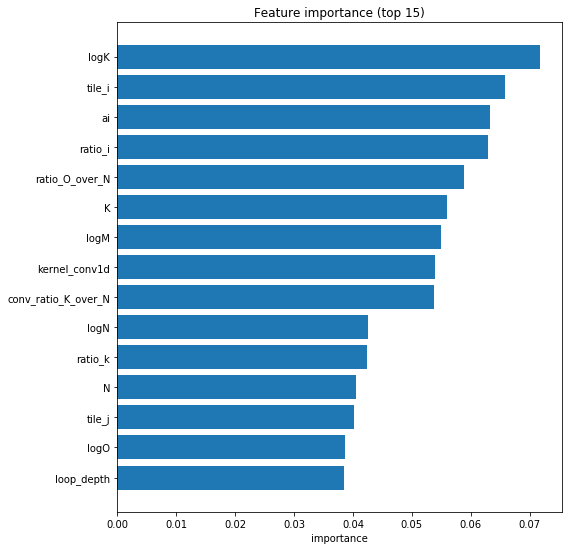

Explainability snapshot (SHAP or permutation):


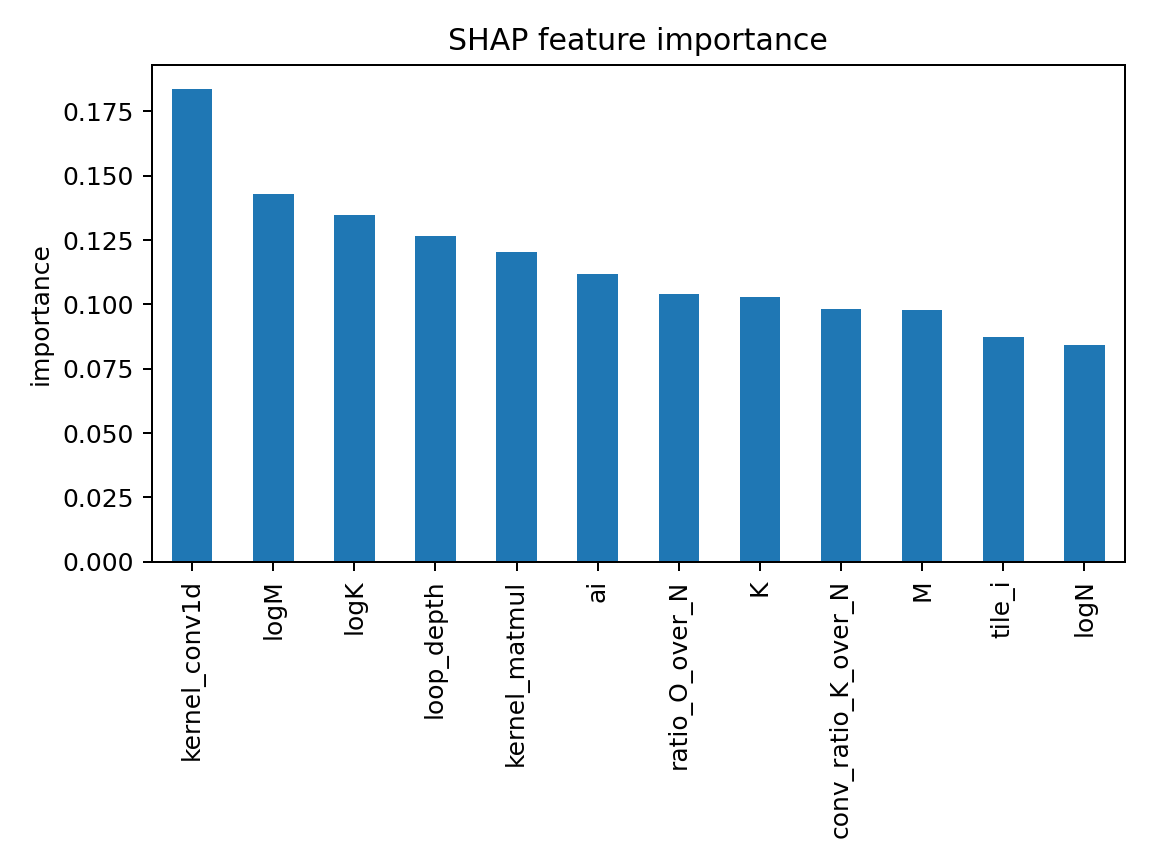

In [6]:
if fi is not None and len(fi):
    topk = 15
    fig = plt.figure(figsize=(8, 4 + 0.25*topk))
    ax = plt.gca()
    use = fi.head(topk).sort_values("importance")
    ax.barh(use["feature"], use["importance"])
    ax.set_title("Feature importance (top 15)")
    ax.set_xlabel("importance")
    plt.tight_layout(); plt.show()
else:
    print("feature_importance.csv not found. After training with a tree-based model, this will appear.")

exp_png = ART / "explain.png"
if exp_png.exists():
    print("Explainability snapshot (SHAP or permutation):")
    display(Image(filename=str(exp_png)))
else:
    print("explain.png not found — run `make explain` or `make workflow`.")


,kernel,acc,f1_macro,regret_median,speedup_median,coverage,n
0,matmul,0.883598,0.625272,1.0,6.946566,1.0,189
1,conv1d,0.718459,0.22718,1.0,1.4995,1.0,753
2,stencil2d,1.0,1.0,1.0,1.052629,1.0,179


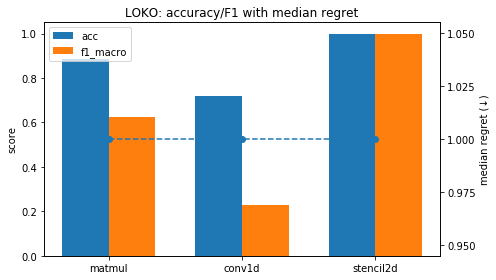

In [7]:
if loko:
    lokodf = pd.DataFrame(loko).T.reset_index().rename(columns={"index":"kernel"})
    display(lokodf[["kernel","acc","f1_macro","regret_median","speedup_median","coverage","n"]])

    x = np.arange(len(lokodf)); w = 0.35
    fig, ax1 = plt.subplots(figsize=(7,4))
    ax1.bar(x - w/2, lokodf["acc"], width=w, label="acc")
    ax1.bar(x + w/2, lokodf["f1_macro"], width=w, label="f1_macro")
    ax1.set_xticks(x); ax1.set_xticklabels(lokodf["kernel"])
    ax1.set_ylim(0, 1.05)
    ax1.set_ylabel("score")
    ax1.legend(loc="upper left")

    ax2 = ax1.twinx()
    ax2.plot(x, lokodf["regret_median"], marker="o", linestyle="--")
    ax2.set_ylabel("median regret (↓)")
    ax2.yaxis.set_major_locator(MaxNLocator(nbins=5))
    ax1.set_title("LOKO: accuracy/F1 with median regret")
    plt.tight_layout(); plt.show()
else:
    print("loko.json not found — run `make loko` or `make workflow`.")


In [8]:
if cv:
    display(pd.DataFrame({k:[v] for k,v in cv.items()}))
else:
    print("cv.json not found — run `make cv` or `make workflow`.")


,k,acc_mean,f1_macro_mean
0,5,0.742796,0.441462


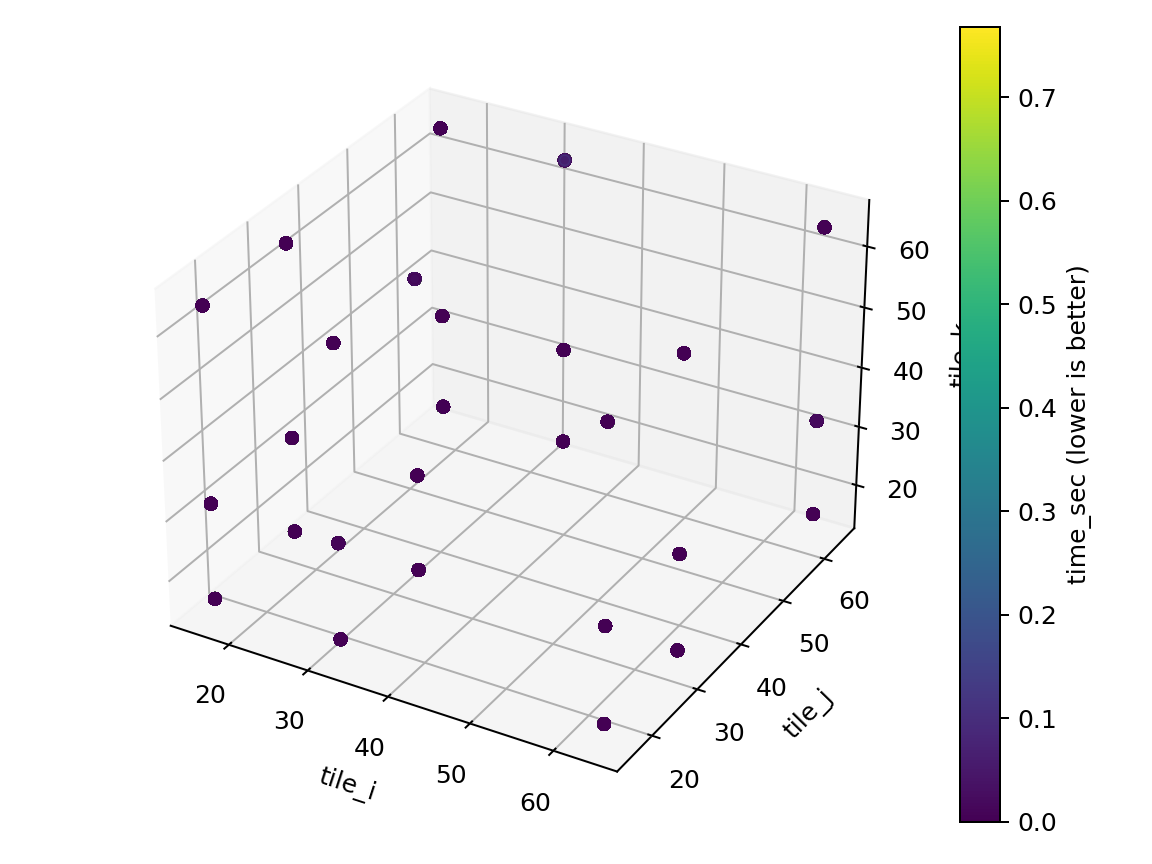

,kernel_matmul,kernel_conv1d,kernel_stencil2d,loop_depth,ai,N,M,K,logN,logM,...,mis_j,mis_k,conv_ratio_K_over_N,choice,time_sec,checksum,compile_macros,kernel,group_id,best_choice
0,1,0,0,3,21.333333,128,128,128,4.85203,4.85203,...,0.0,0.0,0.0,baseline,0.003088,0.0,-DTILE_I=16 -DTILE_J=32 -DTILE_K=16,matmul,759,omp
1,1,0,0,3,21.333333,128,128,128,4.85203,4.85203,...,0.0,0.0,0.0,baseline,0.002870,0.0,-DTILE_I=16 -DTILE_J=16 -DTILE_K=16,matmul,756,omp
2,1,0,0,3,21.333333,128,128,128,4.85203,4.85203,...,0.0,0.0,0.0,baseline,0.002729,0.0,-DTILE_I=16 -DTILE_J=16 -DTILE_K=64,matmul,758,omp
3,1,0,0,3,21.333333,128,128,128,4.85203,4.85203,...,0.0,0.0,0.0,baseline,0.002851,0.0,-DTILE_I=16 -DTILE_J=16 -DTILE_K=32,matmul,757,omp
4,1,0,0,3,21.333333,128,128,128,4.85203,4.85203,...,0.0,0.0,0.0,baseline,0.002840,0.0,-DTILE_I=16 -DTILE_J=32 -DTILE_K=32,matmul,760,omp
5,1,0,0,3,21.333333,128,128,128,4.85203,4.85203,...,0.0,0.0,0.0,baseline,0.002969,0.0,-DTILE_I=16 -DTILE_J=32 -DTILE_K=64,matmul,761,omp
6,1,0,0,3,21.333333,128,128,128,4.85203,4.85203,...,0.0,0.0,0.0,baseline,0.002729,0.0,-DTILE_I=16 -DTILE_J=64 -DTILE_K=16,matmul,762,omp
7,1,0,0,3,21.333333,128,128,128,4.85203,4.85203,...,0.0,0.0,0.0,baseline,0.002717,0.0,-DTILE_I=16 -DTILE_J=64 -DTILE_K=32,matmul,763,omp
8,1,0,0,3,21.333333,128,128,128,4.85203,4.85203,...,0.0,0.0,0.0,baseline,0.002704,0.0,-DTILE_I=16 -DTILE_J=64 -DTILE_K=64,matmul,764,omp
9,1,0,0,3,21.333333,128,128,128,4.85203,4.85203,...,0.0,0.0,0.0,baseline,0.002745,0.0,-DTILE_I=32 -DTILE_J=16 -DTILE_K=16,matmul,765,omp


Rows: 9,072


In [9]:
tile_png = ART / "tile_runtime_3d.png"
if tile_png.exists():
    display(Image(filename=str(tile_png)))
else:
    print("tile_runtime_3d.png not found — run `make vis3d` or `make workflow`.")

if df is not None:
    display(df.head(10))
    print(f"Rows: {len(df):,}")
else:
    print("dataset.csv not found.")


In [10]:
report = load_json("report.json")
cv     = load_json("cv.json")
loko   = load_json("loko.json")

fi = None
fi_csv = ART / "feature_importance.csv"
if fi_csv.exists():
    fi = pd.read_csv(fi_csv, header=None, names=["feature","importance"])\
           .sort_values("importance", ascending=False)

df = None
dataset_csv = ART / "dataset.csv"
if dataset_csv.exists():
    df = pd.read_csv(dataset_csv)

print("Loaded:")
print(" - report.json:", report is not None)
print(" - cv.json:", cv is not None)
print(" - loko.json:", loko is not None)
print(" - feature_importance.csv:", fi is not None)
print(" - dataset.csv:", df is not None)


Loaded:
 - report.json: True
 - cv.json: True
 - loko.json: True
 - feature_importance.csv: True
 - dataset.csv: True


In [11]:
if df is not None:
    cfg = df.drop_duplicates(subset=["group_id"]) if "group_id" in df.columns else df
    if "best_choice" in cfg.columns:
        print("Label distribution (best_choice):")
        display(cfg["best_choice"].value_counts().to_frame("count"))
    if {"kernel","N"}.issubset(cfg.columns):
        grp = cfg.groupby(["kernel","N"]).size().reset_index(name="n")
        print("Unique (kernel,N) groups:", len(grp))
else:
    print("dataset.csv not found.")


Label distribution (best_choice):


,count
vec_pragma,656
baseline,191
omp,147
tile_unroll_omp,88
tile_omp,35
unroll,14
tile,2
tile_unroll,1


Unique (kernel,N) groups: 21


# GNN

In [ ]:
# === Setup & Load (no retraining) ===
from pathlib import Path
import json, math, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ART = Path("../artifacts")  # change to Path("artifacts") if notebook is at repo root
assert ART.exists(), f"Artifacts folder not found at {ART.resolve()}"

# Helper loaders (graceful if missing)
def read_json(p):
    p = ART / p
    return json.loads(p.read_text()) if p.exists() else None

def read_csv(p):
    p = ART / p
    return pd.read_csv(p) if p.exists() else None

report          = read_json("report.json")                 # tabular model final report
loko            = read_json("loko.json")                   # leave-one-kernel-out metrics
cv              = read_json("cv.json")                     # k-fold CV summary
gnn_report      = read_json("gnn_report.json")             # GNN acc/F1 on held-out set
gnn_regret_sum  = read_json("gnn_regret_summary.json")     # GNN regret summary (all)
gnn_regret_det  = read_csv("gnn_regret_details.csv")       # GNN per-config details
feat_importance = read_csv("feature_importance.csv")       # may exist for tree models
dataset         = read_csv("dataset.csv")                  # full dataset (for counts)

# Quick sanity print
print("Loaded:", {
    "report": bool(report), "loko": bool(loko), "cv": bool(cv),
    "gnn_report": bool(gnn_report), "gnn_regret_summary": bool(gnn_regret_sum),
    "gnn_regret_details": gnn_regret_det.shape if gnn_regret_det is not None else None,
    "feature_importance": feat_importance.shape if feat_importance is not None else None,
    "dataset_rows": len(dataset) if dataset is not None else None,
})

# Convenience: extract a compact row of key numbers we’ll reference later
metrics = {}

if report:
    metrics.update({
        "tab_acc": report.get("test_acc"),
        "tab_f1": report.get("test_f1_macro"),
        "tab_model": report.get("model_picked"),
        "cv_acc": (cv or {}).get("acc_mean"),
        "cv_f1": (cv or {}).get("f1_macro_mean"),
    })

if gnn_report:
    metrics.update({
        "gnn_acc": gnn_report.get("acc"),
        "gnn_f1": gnn_report.get("f1_macro"),
    })
if gnn_regret_sum:
    metrics.update({
        "gnn_regret_median": gnn_regret_sum.get("regret_median"),
        "gnn_speedup_median": gnn_regret_sum.get("speedup_vs_baseline_median"),
        "gnn_regret_mean": gnn_regret_sum.get("regret_mean"),
        "gnn_regret_90p": gnn_regret_sum.get("regret_90p"),
    })

pd.DataFrame([metrics])

In [ ]:
# === Confusion Matrix & Label Report for the tabular model ===
if not report:
    print("report.json not found — skip confusion matrix.")
else:
    labels = sorted(report["classes"])
    cm = np.asarray(report["confusion_matrix"], dtype=int)

    fig, ax = plt.subplots(figsize=(5.5, 5))
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    disp.plot(include_values=True, cmap="Blues", ax=ax, colorbar=False)
    ax.set_title(f"Tabular Model ({report['model_picked']}) — Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Per-class precision/recall/F1
    cr = pd.DataFrame(report["classification_report"]).T
    display(cr.round(3))

In [ ]:
# === LOKO per-kernel metrics (accuracy/F1/regret/speedup) ===
if not loko:
    print("loko.json not found — skipping LOKO plots.")
else:
    loko_df = (pd.DataFrame(loko).T
               .reset_index()
               .rename(columns={"index":"kernel"}))
    display(loko_df[["kernel","model_family","acc","f1_macro","regret_median","speedup_median","coverage","n"]])

    # Bars: accuracy & F1
    fig, ax = plt.subplots(figsize=(6.5, 3.8))
    x = np.arange(len(loko_df))
    w = 0.35
    ax.bar(x - w/2, loko_df["acc"], width=w, label="Accuracy")
    ax.bar(x + w/2, loko_df["f1_macro"], width=w, label="Macro-F1")
    ax.set_xticks(x, loko_df["kernel"])
    ax.set_ylim(0, 1.05)
    ax.set_title("LOKO (Train on two kernels, test on held-out)")
    ax.legend()
    plt.tight_layout(); plt.show()

    # Bars: median speedup vs baseline (×)
    fig, ax = plt.subplots(figsize=(6.5, 3.4))
    ax.bar(loko_df["kernel"], loko_df["speedup_median"])
    ax.set_ylabel("Median Speedup vs Baseline (×)")
    ax.set_title("LOKO: Runtime Benefit (Tabular Model)")
    plt.tight_layout(); plt.show()

In [ ]:
# === GNN regret & speedup analysis (uses existing gnn_regret_details.csv) ===
if gnn_regret_det is None or gnn_regret_det.empty:
    print("gnn_regret_details.csv not found — skip GNN analysis.")
else:
    # Per-kernel summary from details (even if summary JSON exists)
    per_k = (gnn_regret_det
             .groupby("kernel")
             .agg(n=("group_id","count"),
                  median_speedup=("speedup_vs_baseline","median"),
                  mean_regret=("regret","mean"),
                  median_regret=("regret","median"))
             .reset_index())
    display(per_k)

    # Plot: per-kernel median speedup
    fig, ax = plt.subplots(figsize=(6.2, 3.6))
    ax.bar(per_k["kernel"], per_k["median_speedup"])
    ax.set_ylabel("Median Speedup vs Baseline (×)")
    ax.set_title("GNN: Median Speedup per Kernel")
    plt.tight_layout(); plt.show()

    # Plot: regret distribution per kernel (robust to empty slices)
    labels_k, datasets = [], []
    for k in per_k["kernel"].tolist():
        arr = (gnn_regret_det.loc[gnn_regret_det["kernel"]==k, "regret"]
                               .dropna()
                               .to_numpy(dtype=float))
        if arr.size > 0:
            labels_k.append(k); datasets.append(arr)

    if datasets:
        fig, ax = plt.subplots(figsize=(6.2, 3.6))
        ax.violinplot(datasets, showmeans=True, showmedians=True, showextrema=True)
        ax.set_xticks(np.arange(1, len(labels_k)+1), labels_k)
        ax.set_ylabel("Regret (pred_time / best_time)")
        ax.set_title("GNN: Regret Distribution by Kernel")
        plt.tight_layout(); plt.show()

    # Plot: overall regret CDF
    reg = np.sort(gnn_regret_det["regret"].dropna().to_numpy(dtype=float))
    cdf = np.arange(1, reg.size+1) / float(reg.size)
    fig, ax = plt.subplots(figsize=(6.2, 3.6))
    ax.plot(reg, cdf)
    ax.set_xlabel("Regret")
    ax.set_ylabel("CDF")
    ax.set_title("GNN: Regret CDF (All Kernels)")
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    plt.tight_layout(); plt.show()

    # Optional: confusion (best vs pred) from details, if present
    if {"best_choice","pred_choice"}.issubset(gnn_regret_det.columns):
        true = gnn_regret_det["best_choice"].astype(str)
        pred = gnn_regret_det["pred_choice"].astype(str)
        labels_conf = sorted(set(true) | set(pred))
        cm = confusion_matrix(true, pred, labels=labels_conf)
        fig, ax = plt.subplots(figsize=(6, 5))
        disp = ConfusionMatrixDisplay(cm, display_labels=labels_conf)
        disp.plot(ax=ax, cmap="Purples", colorbar=False, values_format="d")
        ax.set_title("GNN: Confusion Matrix (Pred vs Best)")
        plt.tight_layout(); plt.show()

In [ ]:
# === Feature importances (tree models only) ===
if feat_importance is None:
    print("feature_importance.csv not found or model not tree-based.")
else:
    fi = feat_importance.sort_values(by=feat_importance.columns[1], ascending=False)
    fi.columns = ["feature","importance"]
    top = fi.head(20)
    fig, ax = plt.subplots(figsize=(7.5, 5))
    ax.barh(top["feature"][::-1], top["importance"][::-1])
    ax.set_xlabel("Importance")
    ax.set_title("Top Feature Importances (Tabular Model)")
    plt.tight_layout(); plt.show()

In [ ]:
# Save last few figures to files in artifacts/
save = False  # switch to True to save
if save:
    out = ART
    for i, f in enumerate(plt.get_fignums(), 1):
        plt.figure(f).savefig(out / f"figure_{i:02d}.png", dpi=200)
    print("Saved figures to:", out)

In [ ]:
# === Auto-written summary (edit as needed) ===
def fmt(x, nd=3):
    return "—" if x is None else f"{x:.{nd}f}"

lines = []

lines.append("## Results & Research Summary")
if report:
    lines.append(f"- **Final tabular model:** `{report['model_picked']}`")
    lines.append(f"- **Test accuracy / macro-F1:** {fmt(metrics.get('tab_acc'))} / {fmt(metrics.get('tab_f1'))}")
if cv:
    lines.append(f"- **Cross-validated (k={cv.get('k', '—')}):** acc={fmt(metrics.get('cv_acc'))}, macro-F1={fmt(metrics.get('cv_f1'))}")

if loko:
    # show a compact table row string
    ldf = (pd.DataFrame(loko).T
           .reset_index().rename(columns={"index":"kernel"}))
    for _, r in ldf.iterrows():
        lines.append(f"- **LOKO {r.kernel}** — acc={fmt(r.acc)}, F1={fmt(r.f1_macro)}, "
                     f"median regret={fmt(r.regret_median)}, median speedup×={fmt(r.speedup_median)}")

if gnn_report or gnn_regret_sum:
    lines.append(f"- **GNN (held-out set)** — acc={fmt(metrics.get('gnn_acc'))}, macro-F1={fmt(metrics.get('gnn_f1'))}")
    lines.append(f"- **GNN runtime** — median regret={fmt(metrics.get('gnn_regret_median'))}, "
                 f"median speedup×={fmt(metrics.get('gnn_speedup_median'))}, "
                 f"mean regret={fmt(metrics.get('gnn_regret_mean'))}, 90p regret={fmt(metrics.get('gnn_regret_90p'))}")

lines.append(
    "- **Interpretability & design:** grouped stratified CV, regret-aware model selection, small-output OMP guard"
    " for conv1d, and per-kernel hybrid verify (top-K) in LOKO. "
    "Plots quantify kernel-wise speedups and regret distributions, while confusion matrices expose class confusions."
)

md = "\n".join(lines)
print(md)